# Dataset 

In [1]:
from datasets.datasets import UrbanSound8KDataset, get_data_loaders

data_csv='/data/urbansound8k/UrbanSound8K.csv'
root_dir='/data/urbansound8k'
train_fold=[1,2,3,4,5,6,7,8]
val_fold=[10]
test_fold=[9]

train_loader, val_loader, test_loader = get_data_loaders(data_csv, root_dir, train_fold, val_fold, test_fold, batch_size=32, mode="attack")

In [ ]:
from collections import Counter

all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.cpu().numpy())
label_counts = Counter(all_labels)
label_counts

Counter({3: 100,
         2: 100,
         9: 100,
         4: 100,
         0: 100,
         7: 96,
         5: 93,
         8: 83,
         1: 33,
         6: 32})

In [ ]:
import matplotlib.pyplot as plt
import os
# Fetch the first batch from the train_loader
for batch_idx, (data, labels) in enumerate(train_loader):
    # Print the shape of the data and labels
    print(f"Batch {batch_idx+1}")
    print(f"Data shape: {data.shape}")  # Should be [batch_size, 128, 84] if correct
    print(f"Labels shape: {labels.shape}")
    
    # Take the first example in the batch
    example_spectrogram = data[0].numpy()
    example_label = labels[0].item()
    
    # Get the corresponding file information from the dataset annotations
    annotation_idx = train_loader.dataset.annotations.index[batch_idx * len(data)]
    file_name = train_loader.dataset.annotations.iloc[annotation_idx, 0]
    fold_number = train_loader.dataset.annotations.iloc[annotation_idx, 5]
    
    # Print the file name, fold number, and label
    print(f"File: {file_name}")
    print(f"Fold: {fold_number}")
    print(f"Label: {example_label}")
    
    # Plot the mel-spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(example_spectrogram, aspect='auto', origin='lower')
    plt.title(f"Mel-Spectrogram Example - Label: {example_label}")
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency Bands')
    
    # Save the plot with detailed filename
    save_path = f'/home/ilias/projects/adversarial_thesis/data/mel_spectrogram_fold{fold_number}_label{example_label}_{os.path.splitext(file_name)[0]}.png'
    plt.savefig(save_path)
    plt.close()
    break

Batch 1
Data shape: torch.Size([32, 128, 84])
Labels shape: torch.Size([32])
File: 100032-3-0-0.wav
Fold: 5
Label: 0


# Model

In [5]:
from models.models import BaselineCNN
import torch 

model = BaselineCNN(num_classes=10)
model.load_state_dict(torch.load('/home/ilias/projects/adversarial_thesis/models/baseline_cnn.pth'))
model.eval() 

/tmp/ipykernel_44426/2441345227.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/ilias/projects/adversarial_thesis/models/baseline

BaselineCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10240, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
from loops.trainer import test

test(test_loader=test_loader, model=model, device = torch.device("cpu"))

Testing model...


Evaluating:  27%|██▋       | 7/26 [00:01<00:03,  5.66it/s]/home/ilias/miniconda3/envs/adversarial_thesis/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=4096 is too large for input signal of length=3749
  warnings.warn(
Evaluating: 100%|██████████| 26/26 [00:04<00:00,  5.67it/s]

Test Loss: 3.6728, Test Accuracy: 0.7537


(3.6727507506910793, 0.7536764705882353)

# Attacks

### PSO Attack example

Load audio

In [11]:
import librosa
import IPython

audio_file = "/data/urbansound8k/fold10/15544-5-0-8.wav"
IPython.display.display(IPython.display.Audio(audio_file))

Plot original waveform

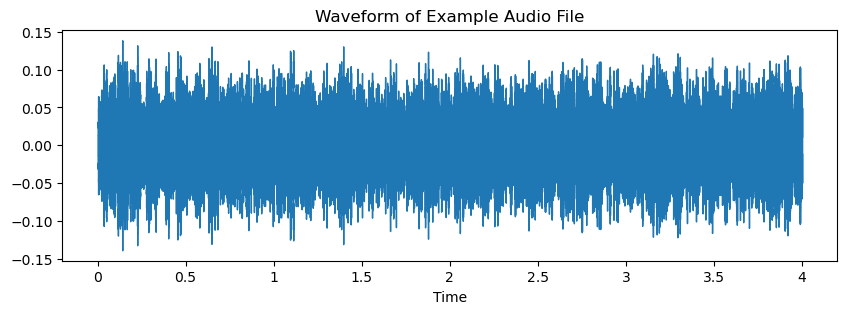

In [23]:
import matplotlib.pyplot as plt

original_audio, sr = librosa.load(audio_file)

# Plot the waveform
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(original_audio, sr=sr, ax=ax)

# Customize the plot as needed
ax.set(title='Waveform of Example Audio File')
ax.label_outer()
plt.show()

Create noise & plot noise

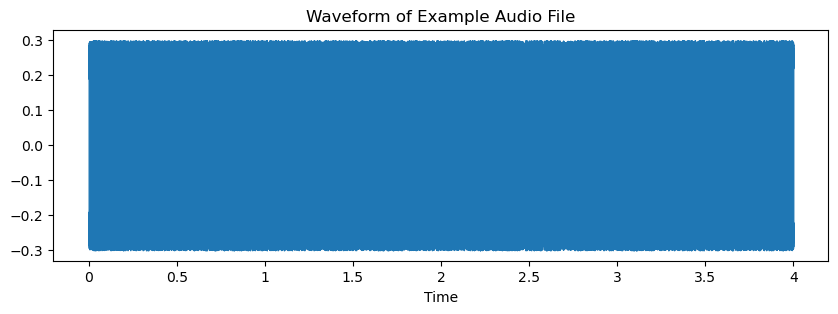

In [22]:
import numpy as np

epsilon = 0.3

noise = np.random.uniform(-1, 1, size=original_audio.shape) * epsilon

# Plot the waveform
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(noise, sr=sr, ax=ax)

# Customize the plot as needed
ax.set(title='Waveform of Example Audio File')
ax.label_outer()
plt.show()

Compute SNR

In [16]:
from utils.utils import calculate_snr

snr = calculate_snr(original_audio, noise)
print(f"SNR = {snr}")

SNR = -13.698237972607895


Perturbed audio

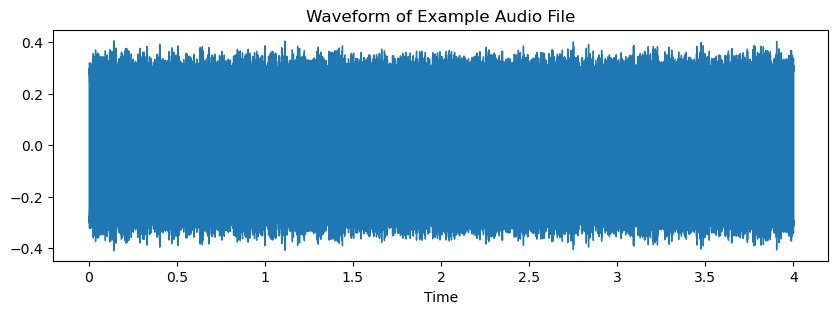

In [ ]:
perturbed = original_audio + noise
librosa.output.write_wav('/home/ilias/projects/adversarial_thesis/data/perturbed.wav', perturbed, sr=22010)
# Plot the waveform
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(perturbed, sr=sr, ax=ax)

# Customize the plot as needed
ax.set(title='Waveform of Example Audio File')
ax.label_outer()
plt.show()

In [ ]:
IPython.display.display(IPython.display.Audio(audio_file))